In [1]:
import sys
import logging

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [6]:
# !pip install keras

In [7]:
# !pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [4]:
from sagemaker.nyc_taxi_utils import preprocess, feature_engineer

In [5]:
!pwd

/Users/yuleinku/Desktop/project/modeling-project/notebooks


In [8]:
import pandas as pd
path = '~/Desktop/project/data/new-york-city-taxi-fare-prediction/NYC_taxi.csv'
df = pd.read_csv(path, parse_dates=['pickup_datetime'], nrows=500000)

In [13]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [36]:
df = preprocess(df)
df = feature_engineer(df)

In [47]:
df_prescaled = df.copy()
df_scaled = df.drop(['fare_amount'], axis=1)
df_scaled = scale(df_scaled)
cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], axis=1)
df = df_scaled.copy()

In [48]:
X = df.loc[:, df.columns != 'fare_amount'] 
y = df.fare_amount
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
model=Sequential()
model.add(Dense(128, activation= 'relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(8, activation= 'relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs=1)







Epoch 1/1
386750/386750 [==============================] - 17s 43us/step - loss: 13.8115 - mean_squared_error: 13.8115


In [50]:
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))

def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0, 
                                                              high=10000))
    idx = sample.index[0]

    actual_fare = df_prescaled.loc[idx,'fare_amount']
    day_names = ['Monday','Tuesday','Wednesday','Thursday','Friday',
                 'Saturday', 'Sunday']
    day_of_week = day_names[df_prescaled.loc[idx,'day_of_week']]
    hour = df_prescaled.loc[idx,'hour']
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare-actual_fare))

    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour)) 
    print("Actual fare: ${:0.2f}".format(actual_fare))
    print("Predicted fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

predict_random(df_prescaled, X_test, model)

Train RMSE: 3.45
Test RMSE: 3.53
Trip Details: Friday, 0:00hrs
Actual fare: $11.50
Predicted fare: $11.04
RMSE: $0.46


In [14]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] <
                                                 nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] < 
                                               nyc_max_latitude)]

In [15]:
landmarks = {'JFK Airport': (-73.78, 40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)}

In [16]:
import matplotlib.pyplot as plt

def plot_lat_long(df, landmarks, points='Pickup'):
    plt.figure(figsize = (12,12)) # set figure size
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), 
                 '.', markersize=1)
    else:
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), 
                 '.', markersize=1)

    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], 
                '*', markersize=15, alpha=1, color='r') 
        plt.annotate(landmark, (landmarks[landmark][0]+0.005, 
                     landmarks[landmark][1]+0.005), color='r', 
                     backgroundcolor='w') 
 
    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

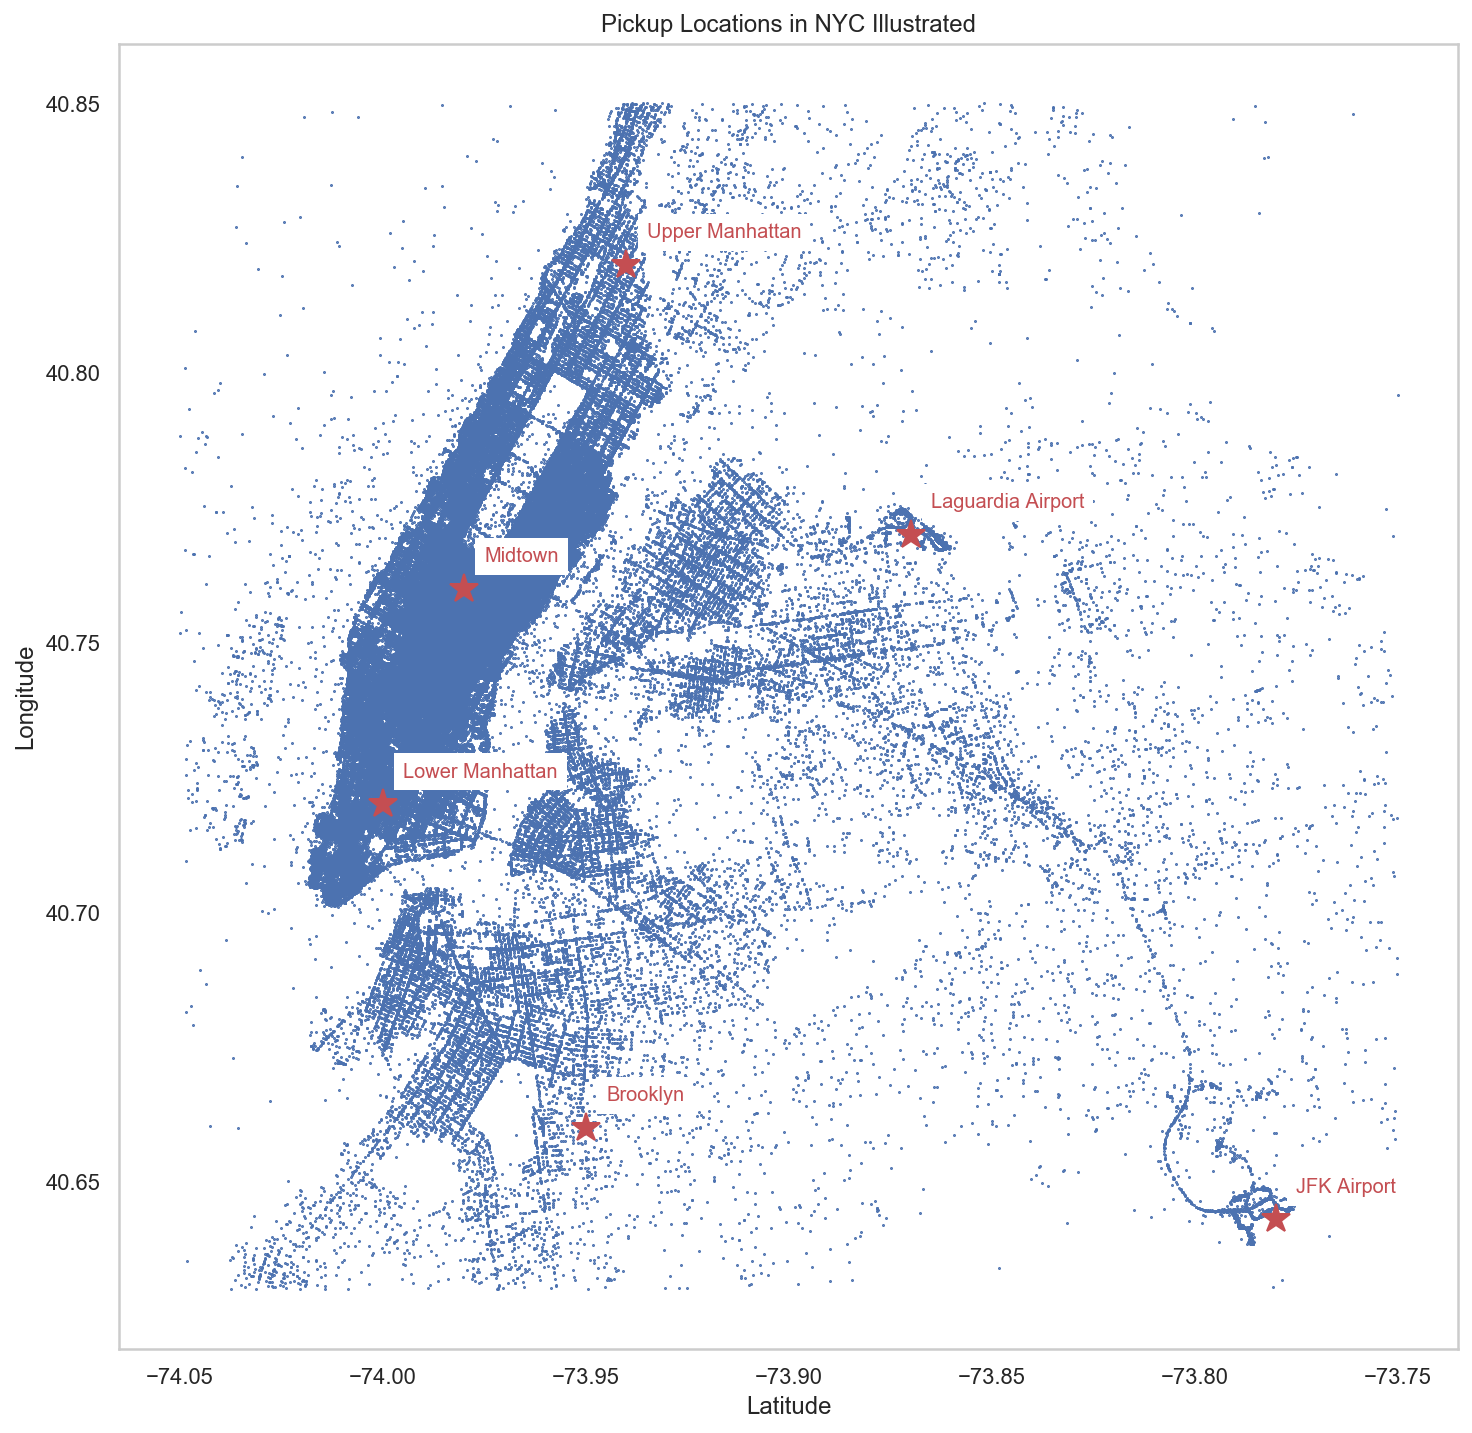

In [17]:
plot_lat_long(df2, landmarks, points='Pickup')

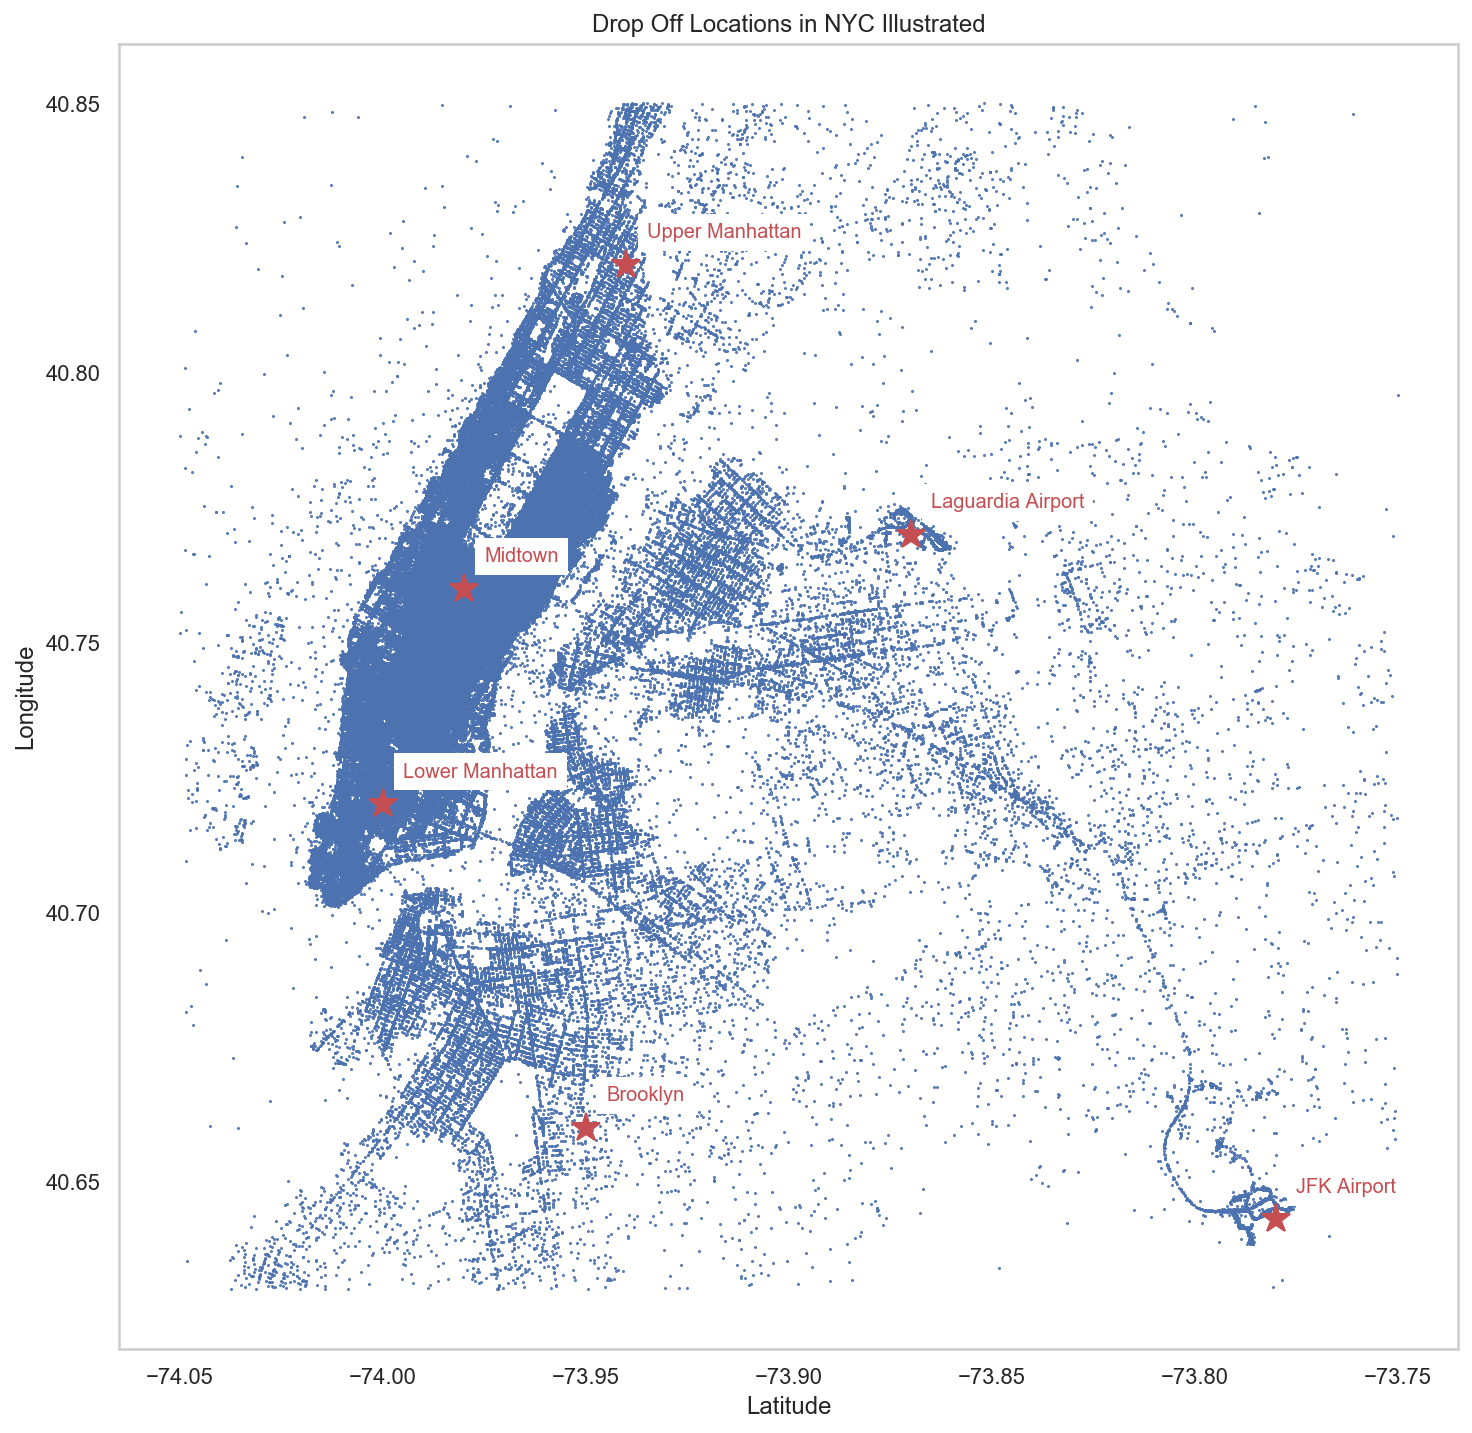

In [19]:
plot_lat_long(df2, landmarks, points='Drop Off')

In [20]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

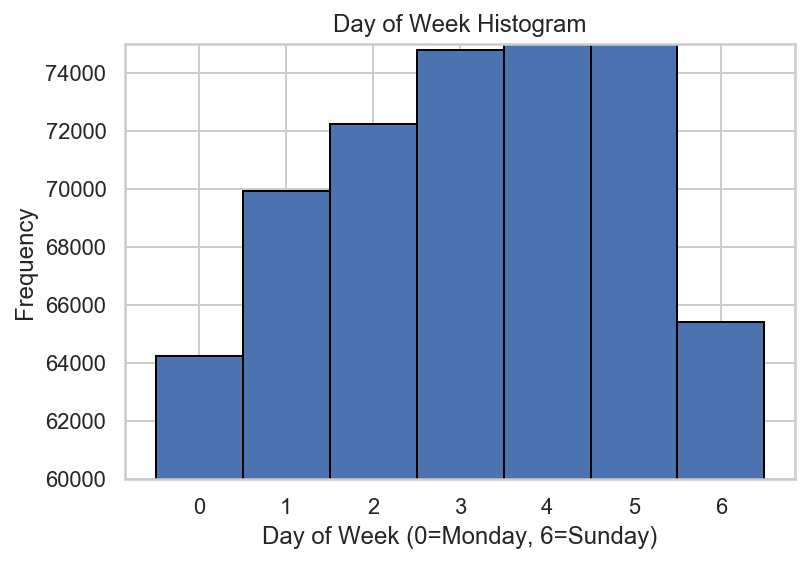

In [21]:
import numpy as np
df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black', 
                            ylim=(60000,75000))
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.title('Day of Week Histogram')
plt.show()

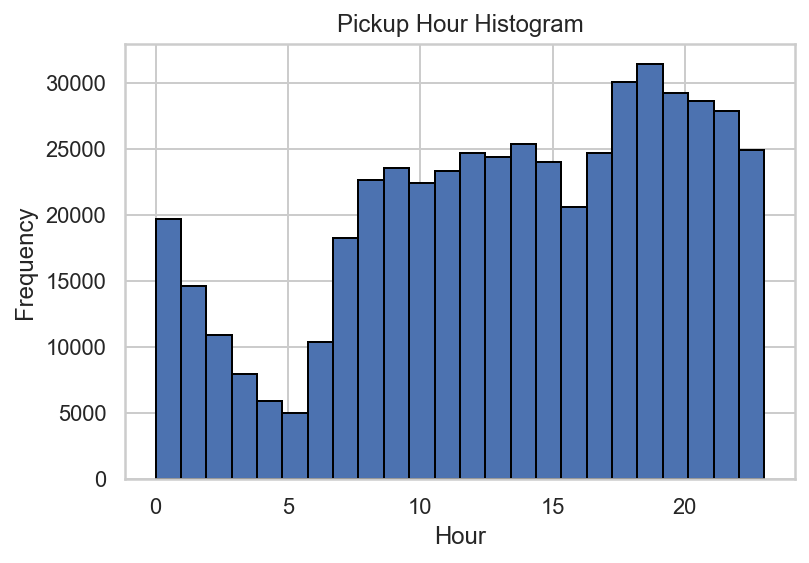

In [22]:
df['hour'].plot.hist(bins=24, ec='black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')
plt.show()

In [23]:
print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64


In [24]:
df = df.dropna()

In [26]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445,2011.739129,6.268617,15.684239,3.042020,13.510843
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391,1.860897,3.437798,8.681092,1.949243,6.511596
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


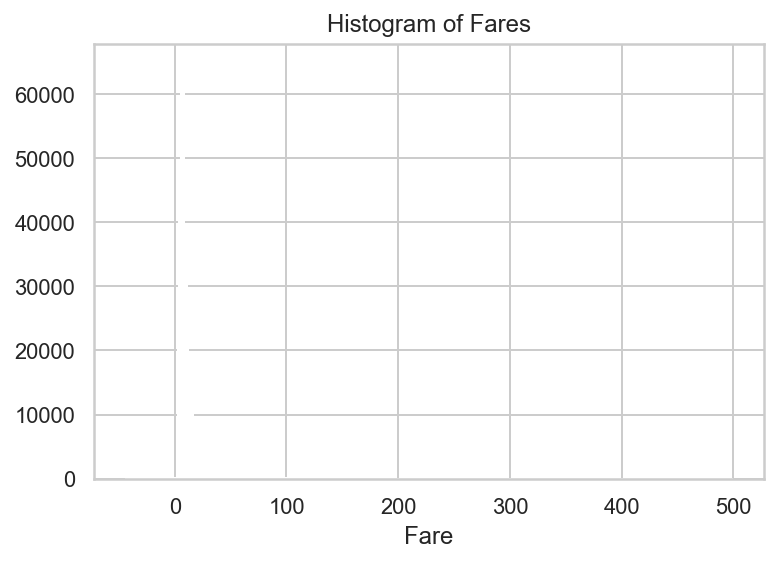

In [27]:
df['fare_amount'].hist(bins=500)
plt.xlabel("Fare")
plt.title("Histogram of Fares")
plt.show()

In [28]:
df = df[(df['fare_amount'] >=0) & (df['fare_amount'] <= 100)]

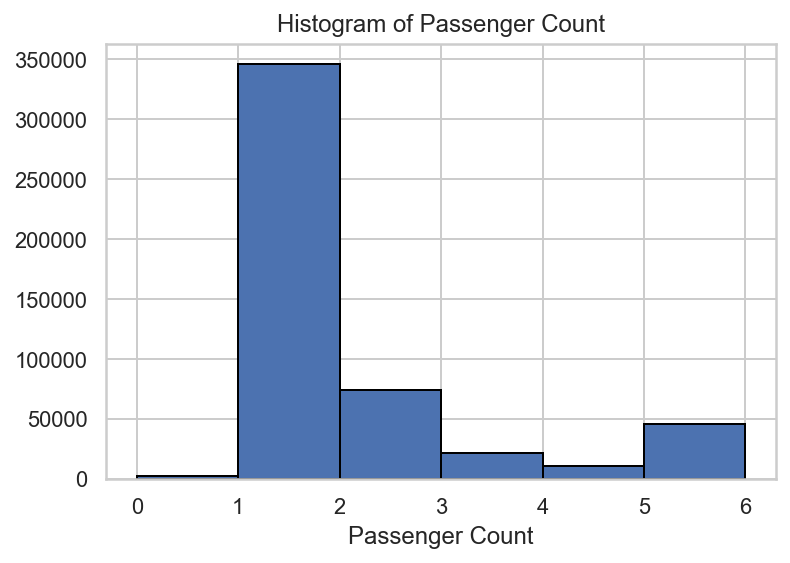

In [29]:
df['passenger_count'].hist(bins=6, ec='black')
plt.xlabel("Passenger Count")
plt.title("Histogram of Passenger Count")
plt.show()

In [30]:
df.loc[df['passenger_count']==0, 'passenger_count'] = 1

/Users/yuleinku/anaconda/envs/sagemaker/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


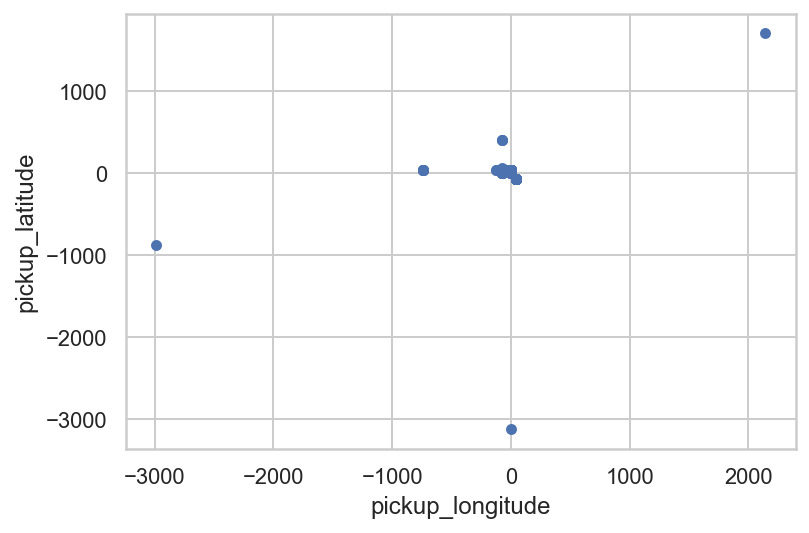

In [31]:
df.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()

In [32]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

# only consider locations within NYC
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] > nyc_min_longitude) & (df[long] <
                                              nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat] > nyc_min_latitude) & (df[lat] < 
                                            nyc_max_latitude)]